<a href="https://colab.research.google.com/github/rosariorogel/DataSciencieRRS/blob/main/RRS_IntroPython_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Complejidad de los datos

### Introducción

En esta sesión analizaremos el tema de complejidad de los datos y algunas técnicas para tratar los efectos de la misma. Este cuaderno se basa parcialmente en el material del curso de limpieza de datos de Kaggle disponible [aquí](https://www.kaggle.com/learn/data-cleaning).

### Gestión de valores omitidos
Elimine los valores que faltan o rellénelos con un flujo de trabajo automatizado.

La limpieza de datos es una parte clave de la ciencia de datos, pero puede ser muy frustrante. ¿Por qué hay campos de texto ilegibles? ¿Qué hacer con los valores que faltan? ¿Por qué las fechas no tienen el formato correcto? ¿Cómo puede solucionar rápidamente la introducción de datos incoherentes? En este tema, aprenderá por qué se ha encontrado con estos problemas y, lo que es más importante, cómo solucionarlos.

En este cuaderno, aprenderá a abordar algunos de los problemas más comunes de limpieza de datos para que pueda analizar sus datos más rápidamente. Realizará cinco ejercicios prácticos con datos reales y desordenados y responderá a algunas de las preguntas más frecuentes sobre la limpieza de datos.

En este cuaderno, veremos cómo tratar los valores faltantes u omitidos.

#### Primer vistazo a los datos

Lo primero que tenemos que hacer es cargar las bibliotecas y el conjunto de datos que vamos a utilizar.

Para la demostración, utilizaremos un conjunto de datos de eventos ocurridos en partidos de fútbol americano. Debido al tamaño del conjunto de datos, lo descargaremos y posteriormente lo cargaremos a nuestro espacio temporal. [Ir a la página de descarga](https://www.kaggle.com/code/alexisbcook/handling-missing-values/data?select=NFL+Play+by+Play+2009-2017+%28v4%29.csv).

In [ ]:
# módulos que usaremos
import pandas as pd
import numpy as np

# cargamos los datos
nfl_data = pd.read_csv("NFL Play by Play 2009-2017 (v4).csv")

# fijamos la semilla para reproducibilidad
np.random.seed(0)

Lo primero que hay que hacer cuando se recibe un nuevo conjunto de datos es echar un vistazo a algunos de ellos. Esto nos permite ver que todo se lee correctamente y nos da una idea de lo que está pasando con los datos. En este caso, vamos a ver si hay valores perdidos u omitidos, que son representados en Python con `NaN`.

In [ ]:
nfl_data.head()

¿Observamos datos faltantes?

¿Cuántos puntos de datos faltantes tenemos?

Bien, ahora sabemos que tenemos algunos valores faltantes. Veamos cuántos tenemos en cada columna.

In [ ]:
# obtenemos el número de datos faltantes por columna
missing_values_count = nfl_data.isnull().sum()

# Revisamos el número de datos faltantes en las primeras 10 columnas del conjunto de datos (tiene 102 columnas en total).
missing_values_count[0:10]

¿Qué opinas de los resultados mostrados? Sería útil saber qué porcentaje de valores faltan en nuestro conjunto de datos para hacernos una idea más precisa de la magnitud del problema:

In [ ]:
print(nfl_data.shape)
a,b = nfl_data.shape
print(a)
print(b)
print(a*b)

In [ ]:
# ¿Cuántos valores faltantes tenemos en total en el conjunto datos?
print(nfl_data.shape)
total_cells = np.product(nfl_data.shape)
total_missing = missing_values_count.sum()

# porcentaje de datos faltante
percent_missing = (total_missing/total_cells) * 100
print(f'Celdas totales: {total_cells:,}')   # Se agrega :, a la derecha de la variable para dar formato de miles
print(f'Celdas con datos faltantes: {total_missing:,}') # Se agrega :, a la derecha de la variable para dar formato de miles
print(f'Porcentaje de datos faltantes: {round(percent_missing,2)}%')

¿Qué opinas del porcentaje de datos faltantes?

#### Averiguar por qué faltan datos

Este es el punto en el que entramos en la parte de la ciencia de datos que solemos llamar "intuición de datos", es decir, "analizar realmente los datos e intentar averiguar por qué son como son y cómo afectarán a nuestro análisis". Puede ser una parte frustrante de la ciencia de datos, especialmente si eres nuevo en este campo y no tienes mucha experiencia. Para tratar los valores que faltan, tendrás que usar tu intuición para averiguar por qué falta el valor. Una de las preguntas más importantes que puede hacerse para averiguarlo es la siguiente:

**¿Este valor falta porque no se registró o porque no existe?**

Si falta un valor porque no existe (como la altura del hijo mayor de alguien que no tiene hijos), no tiene sentido intentar adivinar cuál podría ser. Estos valores probablemente quieras mantenerlos como NaN. Por otro lado, si falta un valor porque no se registró, puede intentar adivinar cuál podría haber sido basándose en los demás valores de esa columna y fila. Esto se llama imputación, ¡y aprenderemos a hacerlo a continuación! :)

Veamos un ejemplo. Observando el número de valores faltantes en el marco de datos nfl_data, nos damos cuenta de que la columna "TimeSecs" tiene muchos valores faltantes:

In [ ]:
# Revisamos el número de datos faltantes en las primeras 10 columnas del conjunto de datos (tiene 102 columnas en total).
missing_values_count[0:10]

Revisando la documentación, podemos ver que esta columna tiene información sobre el número de segundos que quedaban en el partido cuando se hizo la jugada. Esto significa que estos valores probablemente faltan porque no se registraron, y no porque no existan. Por lo tanto, tendría sentido que intentáramos adivinar cuáles deberían ser en lugar de dejarlos como `NaN`.

Por otra parte, hay otros campos, como "PenalizedTeam", en los que también faltan muchos campos. En este caso, sin embargo, el campo falta porque si no hubo penalización no tiene sentido decir qué equipo fue penalizado. Para esta columna, tendría más sentido dejarla vacía o añadir un tercer valor como "ninguno" y utilizarlo para reemplazar los `NaN`.

Si está realizando un análisis de datos muy cuidadoso, este es el punto en el que miraría cada columna individualmente para averiguar cuál es la mejor estrategia para rellenar los valores que faltan. En el resto de este cuaderno, trataremos algunas técnicas "rápidas y sucias" que pueden ayudarle con los valores que faltan, pero que probablemente acabarán eliminando información útil o añadiendo ruido a los datos.

#### Eliminar valores faltantes
Si tiene prisa o no tiene motivos para averiguar por qué faltan valores, una opción es eliminar las filas o columnas que contengan valores que falten. (Nota: ¡generalmente no se recomienda este enfoque para proyectos importantes! Suele merecer la pena tomarse el tiempo necesario para revisar los datos y examinar una por una todas las columnas con valores faltantes para conocer realmente el conjunto de datos).

Si está seguro de que quiere eliminar las filas con valores faltantes, pandas tiene una función muy útil, dropna() para ayudarle a hacerlo. Vamos a probarla en nuestro conjunto de datos de la NFL.

In [ ]:
# eliminar todos los renglones que contengan un valor faltante u omitido
nfl_data.dropna()

¿Qué sucedió? ¡parece que se han eliminado todos nuestros datos! 😱 Esto se debe a que cada fila de nuestro conjunto de datos tenía al menos un valor faltante. Podríamos tener mejor suerte eliminando todas las columnas que tienen al menos un valor faltante en su lugar.

In [ ]:
# Eliminemos ahora todas las columnas en donde exista un valor faltante
columns_with_na_dropped = nfl_data.dropna(axis=1) #Al agregar el parámetro axis=1 estamos indicando que el criterio sea revisar columnas. Por defecto se revisan renglones (axis=0)
columns_with_na_dropped.head(10)

In [ ]:
columns_with_na_dropped.shape

In [ ]:
#a, b = nfl_data.shape
a = nfl_data.shape[0]
b = nfl_data.shape[1]
print(a)
print(b)

Calcular cuanta información hemos perdido

In [ ]:
print(f"Columnas en el conjunto de datos original: {nfl_data.shape[1]}")
print(f"Columnas restantes tras eliminar datos faltantes: {columns_with_na_dropped.shape[1]}")
print(f"Total de columnas eliminadas: {nfl_data.shape[1] - columns_with_na_dropped.shape[1]}")

#### Rellenar automáticamente los valores que faltan
Otra opción es intentar rellenar los valores que faltan. Para ello, vamos a tomar una pequeña subsección de los datos de la NFL para que se imprima bien.

In [ ]:
# obtenemos un pequeño subconjunto del conjunto de datos de la NFL
subset_nfl_data = nfl_data.loc[:, 'EPA':'Season'].head()
subset_nfl_data

Podemos utilizar la función fillna() de Panda para que rellene por nosotros los valores que faltan en un marco de datos. Una opción que tenemos es especificar con qué queremos que se sustituyan los valores NaN. Aquí, estoy diciendo que me gustaría reemplazar todos los valores NaN con 0.

In [ ]:
# remplazar todos los datos NaN con 0
subset_nfl_data.fillna(0)

Quizás una mejor estrategia sea sustituir los valores que faltan por cualquier valor que le siga directamente en la misma columna. (Esto tiene mucho sentido para conjuntos de datos en los que las observaciones tienen algún tipo de orden lógico).

In [ ]:
# reemplazar todos los NaN con el valor que viene directamente después de él en la misma columna
# y sustituir todos los NaN restantes por 0
subset_nfl_data.fillna(method='bfill', axis=0).fillna(0)

Opciones para el parámetro `method`:

**ffill**

Rellenar valores propagando la última observación válida a la siguiente válida.

**bfill**

Rellenar valores utilizando la siguiente observación válida para rellenar el hueco.

In [ ]:
# reemplazar todos los NaN con el valor que viene directamente antes de él en la misma columna
# y sustituir todos los NaN restantes por 0
subset_nfl_data.fillna(method='ffill', axis=0).fillna(0)

### Escalado y Normalización
Transformar variables numéricas para que tengan propiedades útiles.

#### Cargamos los módulos a utilizar

In [ ]:
%pip install mlxtend

In [ ]:
# módulos a utilizar
import pandas as pd
import numpy as np

# para transformación Box-Cox
from scipy import stats

# para escalado min_max
from mlxtend.preprocessing import minmax_scaling

# módulos de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# fijamos la semilla para reproducibilidad
np.random.seed(0)

#### Escalado frente a normalización: ¿Cuál es la diferencia?

Una de las razones por las que es fácil confundirse entre escalado y normalización es porque los términos a veces se utilizan indistintamente y, para hacerlo aún más confuso, ¡son muy similares! En ambos casos, se transforman los valores de las variables numéricas para que los puntos de datos transformados tengan propiedades útiles específicas. La diferencia es que en el escalado, se cambia el rango de los datos, mientras que en la normalización, cambia la forma de la distribución de los datos.

Hablemos un poco más en profundidad de cada una de estas opciones.

#### Escalado

Esto significa que está transformando sus datos para que se ajusten a una escala específica, como 0-100 o 0-1. Es conveniente escalar los datos cuando se utilizan métodos basados en medidas de la distancia entre los puntos de datos, como las máquinas de vectores de soporte (SVM) o los vecinos más cercanos (KNN). Con estos algoritmos, un cambio de "1" en cualquier característica numérica recibe la misma importancia.

Por ejemplo, puede consultar los precios de algunos productos en yenes y en dólares estadounidenses. Un dólar estadounidense vale unos 100 yenes, pero si no escala los precios, métodos como SVM o KNN considerarán que una diferencia de precio de 1 yen es tan importante como una diferencia de 1 dólar estadounidense. Está claro que esto no encaja con nuestras intuiciones del mundo. Con la divisa, puedes convertir entre divisas. Pero, ¿qué ocurre con la altura y el peso? No está del todo claro cuántas libras equivalen a una pulgada (o cuántos kilogramos equivalen a un metro).

Al escalar las variables, puedes comparar diferentes variables en igualdad de condiciones. Para ayudarte a entender cómo es el escalado, veamos un ejemplo inventado. (No te preocupes, en el siguiente ejercicio trabajaremos con datos reales).

In [ ]:
# generar 1000 puntos de datos extraídos aleatoriamente de una distribución exponencial
original_data = np.random.exponential(size=1000)

# mix-max escala los datos entre 0 y 1
scaled_data = minmax_scaling(original_data, columns=[0])

# graficamos ambos para comparar
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos Originales")
sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Datos Escalados")
plt.show()

Observe que la forma de los datos no cambia, pero que en lugar de ir de 0 a 8, ahora van de 0 a 1.

#### Normalización
El escalado sólo cambia el rango de los datos. La normalización es una transformación más radical. El objetivo de la normalización es cambiar las observaciones para que puedan describirse como una distribución normal.

[Distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal): También conocida como "curva de campana", es una distribución estadística específica en la que aproximadamente el mismo número de observaciones se sitúan por encima y por debajo de la media, la media y la mediana son iguales y hay más observaciones cerca de la media. La distribución normal también se conoce como distribución de Gauss.

En general, normalizará sus datos si va a utilizar una técnica de aprendizaje automático o estadística que asuma que sus datos se distribuyen normalmente. Algunos ejemplos son el análisis discriminante lineal (LDA) y el Bayes ingenuo gaussiano. (Consejo profesional: cualquier método con "gaussiano" en el nombre probablemente asume la normalidad).

El método que estamos utilizando para normalizar aquí se llama Transformación [Box-Cox](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation). Echemos un vistazo rápido a cómo se ve la normalización de algunos datos:

In [ ]:
# normalizar los datos exponenciales con boxcox
normalized_data = stats.boxcox(original_data)

# graficamos ambos para comparar
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos Originales")
sns.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Datos Normalizados")
plt.show()

Observe que la forma de nuestros datos ha cambiado. Antes de la normalización tenían casi forma de L. Pero después de la normalización se parecen más al contorno de una campana (de ahí lo de "curva de campana").

### Análisis de fechas
Ayuda a Python a reconocer fechas compuestas por día, mes y año.

#### Cargamos los módulos y conjunto de datos a utilizar
Trabajaremos con un conjunto de datos que contiene información sobre los desprendimientos de tierra ocurridos entre 2007 y 2016.

In [ ]:
# módulos a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

# cargamos los datos
landslides_filepath = "https://raw.githubusercontent.com/vbatiz/intro-python/main/notebooks/data/landslides.csv"
landslides = pd.read_csv(landslides_filepath)

# fijamos la semilla para reproducibilidad
np.random.seed(0)

#### Comprobar el tipo de datos de nuestra columna de fecha
Empezaremos echando un vistazo a las cinco primeras filas de datos.

In [ ]:
landslides.head()

,id,date,time,continent_code,country_name,country_code,state/province,population,city/town,distance,...,geolocation,hazard_type,landslide_type,landslide_size,trigger,storm_name,injuries,fatalities,source_name,source_link
0,34,3/2/07,Night,NaN,United States,US,Virginia,16000,Cherry Hill,3.40765,...,"(38.600900000000003, -77.268199999999993)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,NBC 4 news,http://www.nbc4.com/news/11186871/detail.html
1,42,3/22/07,NaN,NaN,United States,US,Ohio,17288,New Philadelphia,3.33522,...,"(40.517499999999998, -81.430499999999995)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,Canton Rep.com,http://www.cantonrep.com/index.php?ID=345054&C...
2,56,4/6/07,NaN,NaN,United States,US,Pennsylvania,15930,Wilkinsburg,2.91977,...,"(40.4377, -79.915999999999997)",Landslide,Landslide,Small,Rain,NaN,NaN,NaN,The Pittsburgh Channel.com,https://web.archive.org/web/20080423132842/htt...
3,59,4/14/07,NaN,NaN,Canada,CA,Quebec,42786,Châteauguay,2.98682,...,"(45.322600000000001, -73.777100000000004)",Landslide,Riverbank collapse,Small,Rain,NaN,NaN,NaN,Le Soleil,http://www.hebdos.net/lsc/edition162007/articl...
4,61,4/15/07,NaN,NaN,United States,US,Kentucky,6903,Pikeville,5.66542,...,"(37.432499999999997, -82.493099999999998)",Landslide,Landslide,Small,Downpour,NaN,NaN,0.0,Matthew Crawford (KGS),NaN


Estaremos trabajando con la columna "date". Revisemos que realmente contenga fechas.

In [ ]:
# Imprimir los primeros renglones de la columna "date"
print(landslides['date'].head())

0     3/2/07
1    3/22/07
2     4/6/07
3    4/14/07
4    4/15/07
Name: date, dtype: object


Al ver los datos podemos asumir como humanos que son datos de fechas, pero esto no significa que Python reconozca que son fechas. Si revisamos la última línea de la función head() notamos que el tipo de dato (dtype) es "object".

Si revisamos la documentación de dtype de pandas, veremos que también hay un dtype específico datetime64. Como el dtype de nuestra columna es object y no datetime64, podemos decir que Python no sabe que esta columna contiene fechas.

También podemos ver sólo el dtype de una columna sin imprimir las primeras filas:

In [ ]:
# Podemos revisar el tipo de dato de una columna
landslides['date'].dtype

dtype('O')

"O" es el código de "objeto", por lo que podemos ver que estos dos métodos nos dan la misma información.

In [ ]:
# También podemos revisar los tipos de dato de todas las columnas
landslides.dtypes

id                        int64
date                     object
time                     object
continent_code           object
country_name             object
country_code             object
state/province           object
population                int64
city/town                object
distance                float64
location_description     object
latitude                float64
longitude               float64
geolocation              object
hazard_type              object
landslide_type           object
landslide_size           object
trigger                  object
storm_name               object
injuries                float64
fatalities              float64
source_name              object
source_link              object
dtype: object

#### Convertir nuestras columnas de fecha a datetime
Ahora que sabemos que nuestra columna de fecha no está siendo reconocida como una fecha, es hora de convertirla para que sea reconocida como una fecha. Esto se llama "analizar fechas" ("parsing dates" en inglés) porque estamos tomando una cadena e identificando las partes que la componen.

Podemos determinar cuál es el formato de nuestras fechas con una guía llamada "directiva strftime", de la que puedes encontrar más información [aquí](https://strftime.org/)]. La idea básica es que hay que señalar donde están las diferentes partes de la fecha y qué signos de puntuación hay entre ellas. Hay muchas partes posibles de una fecha, pero las más comunes son %d para el día, %m para el mes, %y para un año de dos dígitos y %Y para un año de cuatro dígitos.

Algunos ejemplos:

- 1/17/07 tiene el formato "%m/%d/%y".
- 17-1-2007 tiene el formato "%d-%m-%Y".

Si volvemos a mirar la cabecera de la columna "date" (fecha) en el conjunto de datos de desprendimientos, vemos que tiene el formato "month/day/two-digit year" (mes/día/año de dos dígitos), por lo que podemos utilizar la misma sintaxis que en el primer ejemplo para analizar las fechas:

In [ ]:
# crear una nueva columna, date_parsed, con las fechas analizadas
landslides['date_parsed'] = pd.to_datetime(landslides['date'], format="%m/%d/%y")

In [ ]:
# revisamos los primeros datos
landslides['date_parsed'].head()

0   2007-03-02
1   2007-03-22
2   2007-04-06
3   2007-04-14
4   2007-04-15
Name: date_parsed, dtype: datetime64[ns]

Ahora que nuestras fechas están correctamente analizadas, podemos interactuar con ellas de forma útil.

¿Qué pasa si nos encontramos con un error con múltiples formatos de fecha? Mientras estamos especificando el formato de fecha, a veces se encontrará con un error cuando hay múltiples formatos de fecha en una sola columna. Si eso ocurre, puede hacer que pandas intente deducir cuál debería ser el formato de fecha correcto. Puede hacerlo así:

`landslides['date_parsed'] = pd.to_datetime(landslides['Date'], infer_datetime_format=True)`

¿Por qué no utilizar siempre infer_datetime_format = True? Hay dos grandes razones para no hacer que pandas adivine siempre el formato de hora. La primera es que pandas no siempre será capaz de averiguar el formato de fecha correcto, especialmente si alguien se ha puesto creativo con la entrada de datos. La segunda es que es mucho más lento que especificar el formato exacto de las fechas.

#### Seleccionar el día del mes
Ahora que tenemos una columna de fechas analizadas, podemos extraer información como el día del mes en que se produjo un desprendimiento.

In [ ]:
# obtener el día del mes de la columna date_parsed
day_of_month_landslides = landslides['date_parsed'].dt.day
day_of_month_landslides.head()

0     2.0
1    22.0
2     6.0
3    14.0
4    15.0
Name: date_parsed, dtype: float64

In [ ]:
# obtener el mes de la columna
day_of_month_landslides = landslides['date_parsed'].dt.month
day_of_month_landslides.head()

0    3.0
1    3.0
2    4.0
3    4.0
4    4.0
Name: date_parsed, dtype: float64

¿Qué sucede si intentamos hacer lo mismo con la columna "date" original?

In [ ]:
day_lanslides = landslides['date']

#### Trazar el día del mes para comprobar el análisis sintáctico de la fecha
Uno de los mayores peligros al analizar fechas es confundir los meses y los días. La función to_datetime() tiene mensajes de error muy útiles, pero no está de más volver a comprobar que los días del mes que hemos extraído tienen sentido.

Para ello, vamos a trazar un histograma de los días del mes. Esperamos que tenga valores entre 1 y 31 (Con un asterisco en el 31 porque no todos los meses tienen 31 días) y, puesto que no hay razón para suponer que los desprendimientos son más frecuentes en unos días del mes que en otros, esperamos una distribución relativamente uniforme. Veamos si es así:

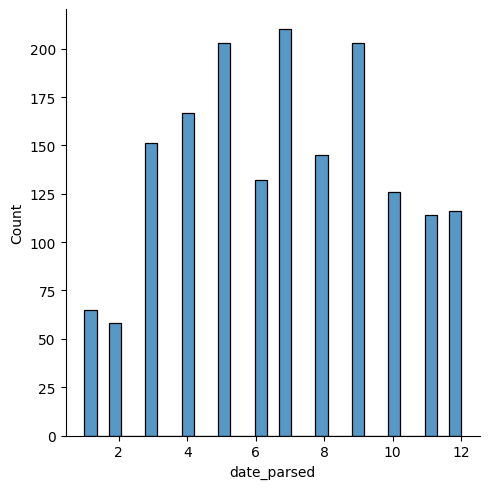

In [ ]:
# remover valores nulos (NaN)
day_of_month_landslides = day_of_month_landslides.dropna()

# graficamos el día del mes
sns.displot(day_of_month_landslides, kde=False, bins=31) #KDE (kernel density estimate) representa los datos mediante una curva de densidad de probabilidad continua en una o varias dimensiones.


### Codificación de caracteres
Evite errores de descodificación Unicode al cargar archivos CSV.

#### Cargamos los módulos que utilizaremos

In [ ]:
# módulos básicos
import pandas as pd
import numpy as np

# módulo de codificación de caracteres
import charset_normalizer

# fijar semilla para reproducibilidad
np.random.seed(0)

#### ¿Qué son las codificaciones?
Las codificaciones de caracteres son conjuntos específicos de reglas para pasar de cadenas binarias de bytes en bruto (que tienen este aspecto: 0110100001101001) a caracteres que forman un texto legible por humanos (como "hola"). Hay muchas codificaciones diferentes, y si intentas leer un texto con una codificación diferente a la original, acabas con un texto confuso llamado "mojibake" (se dice mo-gee-bah-kay). He aquí un ejemplo de mojibake:


æ-‡å-åŒ-ã??


También puedes encontrarte con caracteres "desconocidos". Estos son los que se imprimen cuando no hay correspondencia entre un byte en particular y un caracter en la codificación que estás usando para leer tu cadena de bytes y se ven así:


����������


Los desajustes en la codificación de caracteres son menos comunes hoy en día de lo que solían ser, pero definitivamente siguen siendo un problema. Hay muchas codificaciones de caracteres diferentes, pero la principal que necesitas conocer es UTF-8.


- UTF-8 es la codificación de texto estándar. Todo el código Python está en UTF-8 e, idealmente, todos tus datos deberían estarlo también. Es cuando las cosas no están en UTF-8 cuando tienes problemas.


Era bastante difícil tratar con codificaciones en Python 2, pero afortunadamente en Python 3 es mucho más simple. (Los cuadernos Kaggle sólo usan Python 3.) Hay dos tipos de datos principales que encontrarás cuando trabajes con texto en Python 3. Uno es `string`, que es lo que el texto es por defecto.

In [ ]:
# iniciamos con un string
before = "This is the euro symbol: €"

# verificamos el tipo de dato
type(before)

str

El otro dato es el tipo `bytes`, que es una secuencia de enteros. Puedes convertir una cadena en bytes especificando en qué codificación está:

In [ ]:
# codificarlo a una codificación diferente, sustituyendo los caracteres que provocan errores
after = before.encode("utf-8", errors="replace")

# check the type
print(type(after))
print(after)

<class 'bytes'>
b'This is the euro symbol: \xe2\x82\xac'


Si revisas un objeto `bytes`, verás que tiene una b delante, y quizás algo de texto después. Esto se debe a que los bytes se imprimen como si fueran caracteres codificados en ASCII. (ASCII es una codificación de caracteres antigua que realmente no funciona para escribir otro idioma que no sea el inglés). Aquí puedes ver que nuestro símbolo del euro ha sido reemplazado por algún mojibake que parece "\xe2\x82\xac" cuando se imprime como si fuera una cadena ASCII.

Cuando volvemos a convertir nuestros bytes en una cadena con la codificación correcta, podemos ver que nuestro texto está todo correctamente, ¡lo cual es genial! :)

In [ ]:
# convertirlo de nuevo a utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


Sin embargo, cuando intentamos utilizar una codificación diferente para convertir nuestros bytes en una cadena, obtenemos un error. Esto se debe a que la codificación que estamos intentando utilizar no sabe qué hacer con los bytes que estamos intentando pasarle. Necesitas decirle a Python la codificación en la que se supone que debe estar la cadena de bytes.

Puedes pensar en diferentes codificaciones como diferentes formas de grabar música. Puedes grabar la misma música en un CD, en una cinta de casete o en una de 8 pistas. Aunque la música suene más o menos igual, hay que utilizar el equipo adecuado para reproducir la música de cada formato de grabación. El descodificador correcto es como un reproductor de casetes o de CD. Si intentas reproducir un casete en un reproductor de CD, no funcionará.

In [ ]:
# intenta decodificarlo con codificación ascii
print(after.decode("ascii"))

También podemos tener problemas si intentamos usar la codificación incorrecta para pasar de una cadena a bytes. Como dije antes, las cadenas son UTF-8 por defecto en Python 3, así que si intentamos tratarlas como si estuvieran en otra codificación crearemos problemas.

Por ejemplo, si intentamos convertir una cadena a bytes para ASCII usando encode(), podemos pedir que los bytes sean los que serían si el texto estuviera en ASCII. Sin embargo, como nuestro texto no está en ASCII, habrá algunos caracteres que no podrá manejar. Podemos reemplazar automáticamente los caracteres que ASCII no puede manejar. Sin embargo, si hacemos eso, cualquier carácter que no esté en ASCII será reemplazado por el carácter desconocido. Entonces, cuando convirtamos los bytes de nuevo en una cadena, el carácter será reemplazado por el carácter desconocido. La parte peligrosa de esto es que no hay forma de saber qué carácter debería haber sido. Esto significa que podemos haber convertido nuestros datos en algo inusable.

In [ ]:
# iniciamos con un string
before = "This is the euro symbol: €"

# lo codificamos a un codificación diferente, remplazando los caracteres que marquen error
after = before.encode("ascii", errors = "replace")

# lo convertimos de nuevo a utf-8
print(after.decode("ascii"))

# ¡Hemos perdido la cadena de bytes subyacente original!
# Ha sido reemplazada por la cadena de bytes subyacente para el carácter desconocido :(

This is the euro symbol: ?


Lo anterior es malo y queremos evitarlo. Es mucho mejor convertir todo nuestro texto a UTF-8 tan pronto como podamos y mantenerlo en esa codificación. El mejor momento para convertir texto no UTF-8 a UTF-8 es cuando lees archivos, de lo que hablaremos a continuación.

#### Lectura de archivos con problemas de codificación

La mayoría de los archivos que encuentres probablemente estarán codificados con UTF-8. Esto es lo que Python espera por defecto. Esto es lo que Python espera por defecto, así que la mayoría de las veces no tendrás problemas. Sin embargo, a veces aparecerá un error como éste:

In [ ]:
# intentemos leer un archivo que no está en UTF-8
file_path = "https://raw.githubusercontent.com/vbatiz/intro-python/main/notebooks/data/ks-projects-201612.csv"
kickstarter_2016 = pd.read_csv(file_path)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 7955: invalid start byte

Intentemos detectar la codificación correcta del archivo

In [ ]:
# Ocupamos tener de forma local el archivo para revisarlo
!wget --no-check-certificate https://raw.githubusercontent.com/vbatiz/intro-python/main/notebooks/data/ks-projects-201612.csv -O ks-projects-201612.csv


--2024-01-13 16:15:02--  https://raw.githubusercontent.com/vbatiz/intro-python/main/notebooks/data/ks-projects-201612.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46500324 (44M) [text/plain]
Saving to: ‘ks-projects-201612.csv’

ks-projects-201612. 100%[===================>]  44.35M   192MB/s    in 0.2s    

2024-01-13 16:15:02 (192 MB/s) - ‘ks-projects-201612.csv’ saved [46500324/46500324]



In [ ]:
# revisar los primeros diez mil bytes para inferir la codificación de caracteres
with open("ks-projects-201612.csv", 'rb') as rawdata:
    result = charset_normalizer.detect(rawdata.read(10000))

# verifiquemos que codificación podría ser la correcta
print(result)

{'encoding': 'windows-1250', 'language': 'English', 'confidence': 1.0}


Observamos que charset_normalizer tiene un 100% de confianza en que la codificación correcta es "Windows-1252". Veamos si eso es correcto:

In [ ]:
# leer el archivo con la codificación detectada por charset_normalizer
kickstarter_2016 = pd.read_csv("ks-projects-201612.csv", encoding='Windows-1252')

# revisemos los primeros renglones
kickstarter_2016.head()

<ipython-input-23-a7f6a0ad07e7>:2: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  kickstarter_2016 = pd.read_csv("ks-projects-201612.csv", encoding='Windows-1252')


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


¿Qué pasa si la codificación que infiere charset_normalizer no es la correcta? Como charset_normalizer es básicamente un adivinador elegante, a veces inferirá la codificación incorrecta. Una cosa que puedes intentar es mirar más o menos del archivo y ver si obtienes un resultado diferente y luego probar eso.

#### Guardar tus archivos con codificación UTF-8
Por último, una vez que te hayas tomado la molestia de convertir tu archivo a UTF-8, probablemente querrás mantenerlo así. La forma más sencilla de hacerlo es guardar tus archivos con codificación UTF-8. La buena noticia es que, dado que UTF-8 es la codificación estándar en Python, cuando guardes un archivo se guardará como UTF-8 por defecto:

In [ ]:
# guardemos nuestro archivo (se guardará como UTF-8 por defecto)
kickstarter_2016.to_csv("ks-projects-201612-utf8.csv")

### Introducción de datos incoherentes
Corrija eficazmente los errores tipográficos en sus datos.

#### Cargamos los módulos y conjunto de datos que utilizaremos

In [ ]:
# instalamos el módulo en caso de que no esté precargado
%pip install fuzzywuzzy

In [ ]:
# módulos que ocupamos
import pandas as pd
import numpy as np

# módulos útiles
import fuzzywuzzy
from fuzzywuzzy import process
import charset_normalizer

# cargamos los datos
file_path = "https://raw.githubusercontent.com/vbatiz/intro-python/main/notebooks/data/pakistan_intellectual_capital.csv"
professors = pd.read_csv(file_path)

# fijamos semilla para reproducibilidad
np.random.seed(0)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### Realicemos preprocesamiento de texto

In [ ]:
professors.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


Digamos que nos interesa limpiar la columna "Country" para asegurarnos de que no hay incoherencias en la introducción de datos. Podríamos revisar cada fila a mano, por supuesto, y corregir a mano las incoherencias que encontremos. Pero hay una forma más eficaz de hacerlo.

In [ ]:
# obtengamos todos los valores distintos de la columna 'Country'
countries = professors['Country'].unique()

# ordenemos los nombres y revisemos detenidamente los datos
countries.sort()
countries

array(['Australia', 'Austria', 'Canada', 'China', 'Finland', 'France',
       'Germany', 'Greece', 'Hongkong', 'Ireland', 'Italy', 'Japan',
       'Macau', 'Malaysia', 'Mauritius', 'Netherland', 'New Zealand',
       'Norway', 'Pakistan', 'Portugal', 'Russian Federation',
       'Saudi Arabia', 'Scotland', 'Singapore', 'South Korea',
       'Southkorea', 'Spain', 'Sweden', 'Thailand', 'Turkey', 'Uk',
       'Urbana', 'Usa', 'Usofa'], dtype=object)

¿Qué incosnsistencias observamos?

Lo primero que haremos será pasar los textos a minúsculas y eliminar los espacios adicionales al inicio y final de los textos.

In [ ]:
# convertir a minúsculas
professors['Country'] = professors['Country'].str.lower()

# convertir a título
professors['Country'] = professors['Country'].str.title()

# remover espacios en blanco al inicio y final
professors['Country'] = professors['Country'].str.strip()

In [ ]:
# Otra forma de convertir a minúsculas es utilizando la función apply y str.lower.

professors['Country'] = professors.Country.apply(str.title)
professors.head()

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
1,4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
2,5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
3,6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
4,24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


Utilizar la concordancia difusa para corregir la introducción de datos incoherentes
Muy bien, echemos otro vistazo a la columna "Country" y veamos si hay que limpiar más datos.

In [ ]:
# obtengamos todos los valores distintos de la columna 'Country'
countries = professors['Country'].unique()

# ordenemos los nombres y revisemos detenidamente los datos
countries.sort()
countries

array(['Australia', 'Austria', 'Canada', 'China', 'Finland', 'France',
       'Germany', 'Greece', 'Hongkong', 'Ireland', 'Italy', 'Japan',
       'Macau', 'Malaysia', 'Mauritius', 'Netherland', 'New Zealand',
       'Norway', 'Pakistan', 'Portugal', 'Russian Federation',
       'Saudi Arabia', 'Scotland', 'Singapore', 'South Korea',
       'Southkorea', 'Spain', 'Sweden', 'Thailand', 'Turkey', 'Uk',
       'Urbana', 'Usa', 'Usofa'], dtype=object)

Parece que hay otra incoherencia: "southkorea" y "south korea" deberían ser lo mismo.

Vamos a utilizar el paquete fuzzywuzzy para que nos ayude a identificar las cadenas que más se parecen entre sí. Este conjunto de datos es lo suficientemente pequeño como para que pudiéramos corregir los errores a mano, pero este método no es muy adecuado. (¿Le gustaría corregir mil errores a mano? ¿Y diez mil? Automatizar las cosas lo antes posible suele ser una buena idea. Además, es divertido).

**Coincidencia difusa**: proceso que consiste en encontrar automáticamente cadenas de texto muy similares a la cadena objetivo. En general, una cadena se considera "más parecida" a otra cuantos menos caracteres tendría que cambiar si transformara una cadena en otra. Así, "apple" y "snapple" están a dos cambios de distancia (añadir "s" y "n"), mientras que "in" y "on" están a un cambio (sustituir "i" por "o"). No siempre podrá confiar al 100% en la concordancia difusa, pero normalmente acabará ahorrándole al menos un poco de tiempo.

Fuzzywuzzy devuelve un cociente dadas dos cadenas. Cuanto más se acerque el cociente a 100, menor será la distancia de edición entre las dos cadenas. Aquí, vamos a obtener las diez cadenas de nuestra lista de países que tienen la distancia más cercana a "south korea".

In [ ]:
# obtener las 10 coincidencias más cercanas a "south korea"
matches = fuzzywuzzy.process.extract("south korea", countries, limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

# revisemos
matches

[('South Korea', 100),
 ('Southkorea', 48),
 ('Saudi Arabia', 43),
 ('Norway', 35),
 ('Ireland', 33),
 ('Portugal', 32),
 ('Singapore', 30),
 ('Netherland', 29),
 ('Macau', 25),
 ('Usofa', 25)]

Podemos ver que dos de los elementos de las ciudades están muy cerca de "south korea": "south korea" y "southkorea". Sustituyamos todas las filas de nuestra columna "Country" que tengan una proporción > 47 por "south korea".

Para ello, vamos a escribir una función. (Es una buena idea escribir una función de propósito general que puedas reutilizar si crees que vas a tener que hacer una tarea específica más de una o dos veces. Esto evita que tengas que copiar y pegar código con demasiada frecuencia, lo que ahorra tiempo y puede ayudar a evitar errores).

In [ ]:
# función para remplazar los textos de la columna indicada con base al nivel de coincidencia indicado
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    # obtenemos los valores únicos
    strings = df[column].unique()

    # obtenemos los 10 valores más cercano a nuestra cadena
    matches = fuzzywuzzy.process.extract(string_to_match, strings,
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # filtramos solo las coincidencias con un valore de similitud > min_ratio
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # obtenemos los registros (renglones) de las coincidencias más cercanas en el conjunto de datos
    rows_with_matches = df[column].isin(close_matches)

    # remplazamos los textos con el texto correcto
    df.loc[rows_with_matches, column] = string_to_match

    # mostramos mensaje de que hemos finalizado
    print("¡Listo!")

In [ ]:
# usamos la función para remplazar coincidencias cercanas a "south korea" con "south korea"
replace_matches_in_column(df=professors, column='Country', string_to_match="South Korea")

¡Listo!


Revisamos los datos

In [ ]:
# obtengamos todos los valores distintos de la columna 'Country'
countries = professors['Country'].unique()

# ordenemos los nombres y revisemos detenidamente los datos
countries.sort()
countries

array(['Australia', 'Austria', 'Canada', 'China', 'Finland', 'France',
       'Germany', 'Greece', 'Hongkong', 'Ireland', 'Italy', 'Japan',
       'Macau', 'Malaysia', 'Mauritius', 'Netherland', 'New Zealand',
       'Norway', 'Pakistan', 'Portugal', 'Russian Federation',
       'Saudi Arabia', 'Scotland', 'Singapore', 'South Korea', 'Spain',
       'Sweden', 'Thailand', 'Turkey', 'Uk', 'Urbana', 'Usa', 'Usofa'],
      dtype=object)